In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import csv

In [2]:
pd.set_option('max_colwidth', 800)

In [3]:
import lxml

In [4]:
source = requests.get('https://en.wikipedia.org/wiki/Category:Neighbourhoods_in_Chennai').text 
soup = BeautifulSoup(source, 'lxml')

In [5]:
csv_file = open('chennai.csv', 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Neighbourhood'])

15

In [6]:
mwcg = soup.find_all(class_ = "mw-category-group")

length = len(mwcg) 

for i in range(1, length):  
    lists = mwcg [i].find_all('a')
    for list in lists:
        nbd = list.get('title') 
        csv_writer.writerow([nbd]) 

In [7]:
csv_file.close()

In [9]:
df = pd.read_csv('chennai.csv')

In [10]:
df.head(10)

,Neighbourhood
0,Adambakkam
1,"Adyar, Chennai"
2,Agaram
3,Alandur
4,Alapakkam
5,Alwarpet
6,Alwarthirunagar
7,Aminjikarai
8,Amullaivoyal
9,Andarkuppam


In [11]:
df.shape

(199, 1)

In [12]:
import geocoder

In [13]:
latlngtable=[]
latf=[]
lngf=[]

In [14]:
for place in df['Neighbourhood'][0:199]:
    latlng = None
    i=0   
    while(latlng is None and i<2):
          g = geocoder.bing(place, key = "AkGZ-4V7bLc6jgPQQu0EjhbNdeZFkFO3diqrvXv04SVN-NIG8C6dugh3T-nMsp2q")
          if (len(g) == 1):
             latlng = g.latlng
          else:
             latlng = None
          i+=1
    latlngtable.append(g.latlng)

len(latlngtable)

199

In [15]:
for i in range(0,199):
    if latlngtable[i] != None:
             latf.append(latlngtable[i][0])
             lngf.append(latlngtable[i][1])
    else:
             latf.append('None')
             lngf.append('None')

In [16]:
df["Latitude"] = latf
df["Longitude"] = lngf

In [17]:
#dropping the records without lat and long values
df=df.drop([21,45,161,165]) 

In [18]:
df.head()

,Neighbourhood,Latitude,Longitude
0,Adambakkam,12.9919,80.206
1,"Adyar, Chennai",13.003,80.2519
2,Agaram,10.4555,77.9483
3,Alandur,13.0001,80.2005
4,Alapakkam,12.8968,80.1118


In [19]:
df.shape

(195, 3)

In [20]:
col = 0
explored_lat_lng = []
for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    if (lat, lng) in explored_lat_lng:
        col = col + 1
    else:
        explored_lat_lng.append((lat, lng))

print("Collisions : ", col)

Collisions :  1


In [21]:
import folium 
import numpy as np
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

In [22]:
import json

In [23]:
CLIENT_ID = 'QM0P3KYAIGRLLHIY2ROXNAIZV2CWIAHIAOAWMMQFOL3RR5R3' 
CLIENT_SECRET = 'Q0U0C34EBX2YDLI0F3ANCLGKMCYV2UDIWTTNYHWG3IPEH1EA' 
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QM0P3KYAIGRLLHIY2ROXNAIZV2CWIAHIAOAWMMQFOL3RR5R3
CLIENT_SECRET:Q0U0C34EBX2YDLI0F3ANCLGKMCYV2UDIWTTNYHWG3IPEH1EA


In [24]:
chen_lat = 13.0827 
chen_lng = 80.2707

map_chennai = folium.Map(location=[chen_lat,chen_lng], zoom_start=10)

for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chennai)  
    
map_chennai

In [25]:
def get_category_type(row):
    categories_list = row['Category']  
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [26]:
explore_df_list = []

for i, nbd_name in enumerate(df['Neighbourhood']):  
    
    try :
        nbd_name = df.loc[i, 'Neighbourhood']
        nbd_lat = df.loc[i, 'Latitude']
        nbd_lng = df.loc[i, 'Longitude']

        radius = 1000 
        LIMIT = 30 

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={} \
        &client_secret={}&ll={},{}&v={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, nbd_lat, nbd_lng, VERSION, radius, LIMIT)

        results = json.loads(requests.get(url).text)
        results = results['response']['groups'][0]['items']
        
        nearby = json_normalize(results) 

        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby = nearby.loc[:, filtered_columns]

        columns = ['Name', 'Category', 'Latitude', 'Longitude']
        nearby.columns = columns

        nearby['Category'] = nearby.apply(get_category_type, axis=1)    

        for i, name in enumerate(nearby['Name']):
            s_list = nearby.loc[i, :].values.tolist()  
            f_list = [nbd_name, nbd_lat, nbd_lng] + s_list
            explore_df_list.append(f_list)
    
    except Exception as e:
        pass

In [27]:
len(explore_df_list)

1945

In [1]:
explore_df = pd.DataFrame([item for item in explore_df_list])
explore_df.columns = ['Neighbourhood', 'Neighbourhood Latitude', 'Neighbourhood Longitude', 'Venue Name', 'Venue Category', 'Venue Latitude', 'Venue Longitude']
explore_df.head(30)

NameError: name 'pd' is not defined

In [32]:
chennai_onehot = pd.get_dummies(explore_df[['Venue Category']], prefix="", prefix_sep="")

chennai_onehot['Neighbourhood'] = explore_df['Neighbourhood'] 

fixed_columns = [chennai_onehot.columns[-1]] + chennai_onehot.columns[:-1].values.tolist()
chennai_onehot = chennai_onehot[fixed_columns]

chennai_onehot.head()

,Neighbourhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Andhra Restaurant,Antique Shop,Arcade,...,Theater,Toy / Game Store,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Video Store,Whisky Bar,Women's Store,Yoga Studio
0,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
chennai_grouped = chennai_onehot.groupby('Neighbourhood').mean().reset_index()
chennai_grouped.tail()

,Neighbourhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Andhra Restaurant,Antique Shop,Arcade,...,Theater,Toy / Game Store,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Video Store,Whisky Bar,Women's Store,Yoga Studio
166,Trustpuram,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
167,United India Colony,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.041667,0.000000,0.0,0.0,0.0,0.0
168,Vada Agaram,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
169,Vadapalani,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.066667,0.0,0.0,0.0,0.0
170,Valasaravakkam,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.166667,0.0,0.0,0.0,0.0


In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = chennai_grouped['Neighbourhood']

for ind in np.arange(chennai_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,Train Station,Indian Restaurant,Hotel,Bakery,Metro Station,Pizza Place,Department Store,Asian Restaurant,Kebab Restaurant,Supermarket
1,"Adyar, Chennai",Indian Restaurant,Café,North Indian Restaurant,Rock Club,Italian Restaurant,Pizza Place,Mediterranean Restaurant,Lounge,Middle Eastern Restaurant,Bookstore
2,Alandur,Indian Restaurant,Metro Station,Hotel,Hotel Bar,Train Station,Bakery,Asian Restaurant,Breakfast Spot,Café,Kebab Restaurant
3,Alapakkam,ATM,Movie Theater,Pharmacy,Afghan Restaurant,Accessories Store,Food,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market
4,Alwarpet,Restaurant,Department Store,Hotel,Bakery,Italian Restaurant,Bookstore,Breakfast Spot,Café,Snack Place,Juice Bar


In [37]:
chennai_grouped_clustering = chennai_grouped.drop('Neighbourhood', 1)
chennai_grouped_clustering.head()

,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Andhra Restaurant,Antique Shop,Arcade,Arts & Crafts Store,...,Theater,Toy / Game Store,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Video Store,Whisky Bar,Women's Store,Yoga Studio
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.166667,0.000000,0.0,0.0,0.000000,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.033333,0.0,0.0,0.033333,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.090909,0.000000,0.0,0.0,0.000000,0.0
3,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [39]:
max_range = 20

In [40]:
from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    kgc = chennai_grouped_clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kgc)
    
    score = silhouette_score(kgc, kmeans)
    indices.append(kclusters)
    scores.append(score)

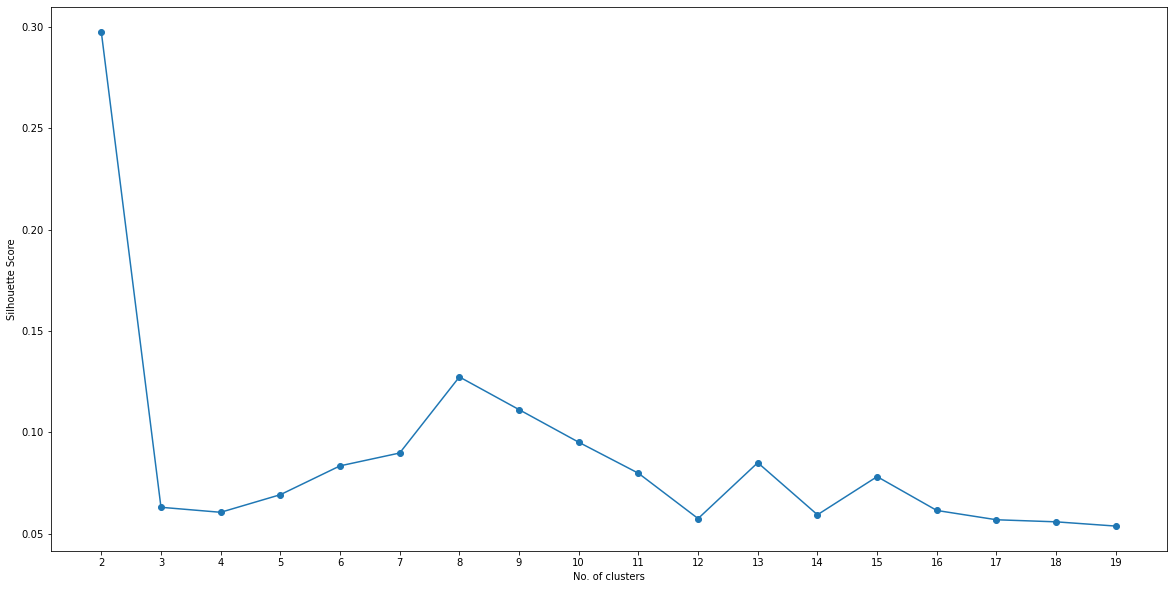

In [41]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

In [42]:
opt = np.argmax(scores) + 2 
opt

2

In [43]:
#we set opt as 8 since 2 is too less
opt = 8

In [44]:
kclusters = opt
kgc = chennai_grouped_clustering
kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit(kgc)

In [45]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [46]:
chennai_merged = df
chennai_merged = chennai_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
chennai_merged.dropna(inplace = True)
chennai_merged['Cluster Labels'] = chennai_merged['Cluster Labels'].astype(int)
chennai_merged.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adambakkam,12.9919,80.206,5,Train Station,Indian Restaurant,Hotel,Bakery,Metro Station,Pizza Place,Department Store,Asian Restaurant,Kebab Restaurant,Supermarket
1,"Adyar, Chennai",13.003,80.2519,5,Indian Restaurant,Café,North Indian Restaurant,Rock Club,Italian Restaurant,Pizza Place,Mediterranean Restaurant,Lounge,Middle Eastern Restaurant,Bookstore
3,Alandur,13.0001,80.2005,5,Indian Restaurant,Metro Station,Hotel,Hotel Bar,Train Station,Bakery,Asian Restaurant,Breakfast Spot,Café,Kebab Restaurant
4,Alapakkam,12.8968,80.1118,3,ATM,Movie Theater,Pharmacy,Afghan Restaurant,Accessories Store,Food,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market
5,Alwarpet,13.0345,80.254,5,Restaurant,Department Store,Hotel,Bakery,Italian Restaurant,Bookstore,Breakfast Spot,Café,Snack Place,Juice Bar


In [47]:
# Create map
map_clusters = folium.Map(location=[chen_lat, chen_lng], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Latitude'], chennai_merged['Longitude'], chennai_merged['Neighbourhood'], chennai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster + 1) + ')', parse_html=True)
    map_clusters.add_child(
        folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7))
       
map_clusters

In [53]:
chennai_grouped_sum = chennai_onehot.groupby('Neighbourhood').sum().reset_index()
chennai_grouped_sum['sumtotal'] = chennai_grouped_sum.sum(axis=1)
chennai_grouped_sum.head()

,Neighbourhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Andhra Restaurant,Antique Shop,Arcade,...,Toy / Game Store,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Video Store,Whisky Bar,Women's Store,Yoga Studio,sumtotal
0,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,12
1,"Adyar, Chennai",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,30
2,Alandur,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,22
3,Alapakkam,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,Alwarpet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,30


In [54]:
chennai_grouped_sum.shape

(171, 179)

In [55]:
food = ['Restaurant', 'Food', 'Bakery', 'Café', 'Joint', 'Diner', 'Bistro', 'Juice', 'Dessert', 'Snack', 'Tea', 'Pizza', 'Sweet', 'Ice Cream']

In [56]:
foodcat=[]
catnames = explore_df['Venue Category'].unique()
for name in catnames:
    i=0
    for foodn in food :
        if(foodn.lower() in name.lower()):
            i+=1
    if(i>0):
        foodcat.append(name)  

len(foodcat) 

52

In [59]:
chennai_grouped_sum['foodsumtotal'] = chennai_grouped_sum[foodcat].sum(axis=1)
chennai_grouped_sum.head()

,Neighbourhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Andhra Restaurant,Antique Shop,Arcade,...,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Video Store,Whisky Bar,Women's Store,Yoga Studio,sumtotal,foodsumtotal
0,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,12,6
1,"Adyar, Chennai",0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,30,22
2,Alandur,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,22,10
3,Alapakkam,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
4,Alwarpet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,30,19


In [224]:
chennai_merged_new = chennai_merged
chennai_merged_new['sumtotal'] = 0
chennai_merged_new['foodsumtotal'] = 0
chennai_merged_new.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,sumtotal,foodsumtotal
0,Adambakkam,12.9919,80.206,5,Train Station,Indian Restaurant,Hotel,Bakery,Metro Station,Pizza Place,Department Store,Asian Restaurant,Kebab Restaurant,Supermarket,0,0
1,"Adyar, Chennai",13.003,80.2519,5,Indian Restaurant,Café,North Indian Restaurant,Rock Club,Italian Restaurant,Pizza Place,Mediterranean Restaurant,Lounge,Middle Eastern Restaurant,Bookstore,0,0
3,Alandur,13.0001,80.2005,5,Indian Restaurant,Metro Station,Hotel,Hotel Bar,Train Station,Bakery,Asian Restaurant,Breakfast Spot,Café,Kebab Restaurant,0,0
4,Alapakkam,12.8968,80.1118,3,ATM,Movie Theater,Pharmacy,Afghan Restaurant,Accessories Store,Food,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,0,0
5,Alwarpet,13.0345,80.254,5,Restaurant,Department Store,Hotel,Bakery,Italian Restaurant,Bookstore,Breakfast Spot,Café,Snack Place,Juice Bar,0,0


In [95]:
chennai_grouped_sum.index = chennai_merged_new.index

In [223]:
chennai_grouped_sum.head()

,Neighbourhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Andhra Restaurant,Antique Shop,Arcade,...,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Video Store,Whisky Bar,Women's Store,Yoga Studio,sumtotal,foodsumtotal
0,Adambakkam,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,12,6
1,"Adyar, Chennai",0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,30,22
3,Alandur,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,22,10
4,Alapakkam,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
5,Alwarpet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,30,19


In [222]:
chennai_merged_new['sumtotal'] = chennai_grouped_sum['sumtotal']
chennai_merged_new['foodsumtotal'] = chennai_grouped_sum['foodsumtotal']
chennai_merged_new.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,sumtotal,foodsumtotal
0,Adambakkam,12.9919,80.206,5,Train Station,Indian Restaurant,Hotel,Bakery,Metro Station,Pizza Place,Department Store,Asian Restaurant,Kebab Restaurant,Supermarket,12,6
1,"Adyar, Chennai",13.003,80.2519,5,Indian Restaurant,Café,North Indian Restaurant,Rock Club,Italian Restaurant,Pizza Place,Mediterranean Restaurant,Lounge,Middle Eastern Restaurant,Bookstore,30,22
3,Alandur,13.0001,80.2005,5,Indian Restaurant,Metro Station,Hotel,Hotel Bar,Train Station,Bakery,Asian Restaurant,Breakfast Spot,Café,Kebab Restaurant,22,10
4,Alapakkam,12.8968,80.1118,3,ATM,Movie Theater,Pharmacy,Afghan Restaurant,Accessories Store,Food,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,3,0
5,Alwarpet,13.0345,80.254,5,Restaurant,Department Store,Hotel,Bakery,Italian Restaurant,Bookstore,Breakfast Spot,Café,Snack Place,Juice Bar,30,19


In [221]:
val = 1
chennai_merged_new.loc[chennai_merged_new['Cluster Labels'] == (val - 1), chennai_merged_new.columns[[0] + np.arange(4, chennai_merged_new.shape[1]).tolist()]].head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,sumtotal,foodsumtotal
43,Gerugambakkam,Bakery,Pizza Place,Fast Food Restaurant,Farm,Yoga Studio,Event Space,Food & Drink Shop,Food,Flower Shop,Flea Market,5,4
54,Iyyapanthangal,Café,Fast Food Restaurant,Bus Station,Bakery,Sandwich Place,Falafel Restaurant,Food,Flower Shop,Flea Market,Farmers Market,12,8
55,Jafferkhanpet,Fast Food Restaurant,Movie Theater,Bakery,Market,Vegetarian / Vegan Restaurant,Indian Restaurant,Sculpture Garden,Dessert Shop,Multicuisine Indian Restaurant,Asian Restaurant,10,7
102,Moulivakkam,Bakery,Pizza Place,Fast Food Restaurant,Farm,Yoga Studio,Event Space,Food & Drink Shop,Food,Flower Shop,Flea Market,8,5
136,Poonamallee,Fast Food Restaurant,Gas Station,Bus Station,Yoga Studio,Food Court,Food,Flower Shop,Flea Market,Farmers Market,Farm,4,1


In [220]:
val = 2
chennai_merged_new.loc[chennai_merged_new['Cluster Labels'] == (val - 1), chennai_merged_new.columns[[0] + np.arange(4, chennai_merged_new.shape[1]).tolist()]].head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,sumtotal,foodsumtotal
18,Athipattu Pudunagar,Train Station,Platform,Yoga Studio,Electronics Store,Food,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,Farm,3,0
28,Choolai,Platform,Soccer Stadium,Indian Restaurant,Train Station,Clothing Store,Dog Run,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,6,1
37,Ernavoor,Brewery,Train Station,Beach,Chinese Restaurant,Yoga Studio,Falafel Restaurant,Food & Drink Shop,Food,Flower Shop,Flea Market,4,1
41,General Kumaramangalam Colony,Train Station,Smoke Shop,Food Truck,Indian Restaurant,Light Rail Station,Asian Restaurant,Falafel Restaurant,Food & Drink Shop,Food,Flower Shop,7,3
63,"Kasturba Nagar, Chennai",Dog Run,Pizza Place,Train Station,Platform,Snack Place,Yoga Studio,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,3,1


In [219]:
val = 3
chennai_merged_new.loc[chennai_merged_new['Cluster Labels'] == (val - 1), chennai_merged_new.columns[[0] + np.arange(4, chennai_merged_new.shape[1]).tolist()]].head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,sumtotal,foodsumtotal
7,Aminjikarai,Fast Food Restaurant,Electronics Store,Pizza Place,Furniture / Home Store,Food,Shopping Mall,Bookstore,Burger Joint,Scenic Lookout,Event Space,18,8
19,Ayanavaram,Tennis Court,Indie Movie Theater,Department Store,Diner,Café,Event Space,Food,Flower Shop,Flea Market,Fast Food Restaurant,5,2
20,Ayyappa Nagar,Pizza Place,Coffee Shop,Bus Station,Café,Yoga Studio,Event Space,Food,Flower Shop,Flea Market,Fast Food Restaurant,4,2
27,Cholavaram,Tea Room,Indian Sweet Shop,Yoga Studio,Food,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,2,2
29,Choolaimedu,Ice Cream Shop,Bakery,Burger Joint,Indian Restaurant,Train Station,Department Store,Juice Bar,Yoga Studio,Falafel Restaurant,Food,9,7


In [218]:
val = 4
chennai_merged_new.loc[chennai_merged_new['Cluster Labels'] == (val - 1), chennai_merged_new.columns[[0] + np.arange(4, chennai_merged_new.shape[1]).tolist()]].head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,sumtotal,foodsumtotal
4,Alapakkam,ATM,Movie Theater,Pharmacy,Afghan Restaurant,Accessories Store,Food,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,3,0
8,Amullaivoyal,Pharmacy,Comfort Food Restaurant,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,1,0
25,Chinnasekkadu,ATM,Pharmacy,Accessories Store,Event Space,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,2,0
38,Erukkanchery,Pharmacy,Pizza Place,Department Store,Dog Run,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,3,1
50,ICF Colony,Pharmacy,ATM,South Indian Restaurant,Plaza,Chinese Restaurant,Bus Station,Event Space,Flower Shop,Flea Market,Fast Food Restaurant,7,2


In [217]:
val = 5
chennai_merged_new.loc[chennai_merged_new['Cluster Labels'] == (val - 1), chennai_merged_new.columns[[0] + np.arange(4, chennai_merged_new.shape[1]).tolist()]].head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,sumtotal,foodsumtotal
59,"Kallikuppam, Ambattur",ATM,Hyderabadi Restaurant,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,17,12
61,Karanodai,ATM,Comfort Food Restaurant,Accessories Store,Event Space,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,11,9
72,"Kolathur, Chennai",ATM,Indian Restaurant,Bus Stop,Event Space,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,5,3
82,Kundrathur,ATM,Bus Station,Pharmacy,Afghan Restaurant,Event Space,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant,8,2
85,Madhavaram Milk Colony,ATM,Park,Bakery,IT Services,Vegetarian / Vegan Restaurant,Dog Run,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,5,1


In [213]:
val = 6
chennai_merged_new.loc[chennai_merged_new['Cluster Labels'] == (val - 1), chennai_merged_new.columns[[0] + np.arange(4, chennai_merged_new.shape[1]).tolist()]].head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,sumtotal,foodsumtotal
0,Adambakkam,Train Station,Indian Restaurant,Hotel,Bakery,Metro Station,Pizza Place,Department Store,Asian Restaurant,Kebab Restaurant,Supermarket,12,6
1,"Adyar, Chennai",Indian Restaurant,Café,North Indian Restaurant,Rock Club,Italian Restaurant,Pizza Place,Mediterranean Restaurant,Lounge,Middle Eastern Restaurant,Bookstore,30,22
3,Alandur,Indian Restaurant,Metro Station,Hotel,Hotel Bar,Train Station,Bakery,Asian Restaurant,Breakfast Spot,Café,Kebab Restaurant,22,10
5,Alwarpet,Restaurant,Department Store,Hotel,Bakery,Italian Restaurant,Bookstore,Breakfast Spot,Café,Snack Place,Juice Bar,30,19
6,Alwarthirunagar,Clothing Store,Fast Food Restaurant,Indian Restaurant,Pizza Place,Movie Theater,Chinese Restaurant,Tea Room,Multiplex,Café,Gym,16,9


In [214]:
val = 7
chennai_merged_new.loc[chennai_merged_new['Cluster Labels'] == (val - 1), chennai_merged_new.columns[[0] + np.arange(4, chennai_merged_new.shape[1]).tolist()]].head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,sumtotal,foodsumtotal
16,Assisi Nagar,Indian Restaurant,Yoga Studio,Event Space,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,Farm,1,1
26,Chintadripet,Indian Restaurant,Multiplex,Bookstore,Dessert Shop,Flea Market,Electronics Store,Café,General Entertainment,Movie Theater,Train,17,9
75,Kosapet,Indian Restaurant,Hotel,Department Store,Yoga Studio,Event Space,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant,12,7
95,Manjambakkam,Indian Restaurant,Lake,Yoga Studio,Event Space,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,2,1
97,Medavakkam,Indian Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Chinese Restaurant,Yoga Studio,Electronics Store,Food,Flower Shop,Flea Market,Fast Food Restaurant,7,7


In [216]:
val = 8
chennai_merged_new.loc[chennai_merged_new['Cluster Labels'] == (val - 1), chennai_merged_new.columns[[0] + np.arange(4, chennai_merged_new.shape[1]).tolist()]].head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,sumtotal,foodsumtotal
179,Thirumudivakkam,Event Space,Yoga Studio,Hyderabadi Restaurant,Food & Drink Shop,Food,Flower Shop,Flea Market,Fast Food Restaurant,Farmers Market,Farm,1,0


In [111]:
avg_sum = chennai_grouped_sum['sumtotal'].mean()
avg_sum

11.374269005847953

In [113]:
avg_quo = (chennai_grouped_sum['foodsumtotal']/chennai_grouped_sum['sumtotal']).mean()
avg_quo

0.4842871760765246

In [189]:
dens = []
for val in range(1,9):
    cluster = chennai_merged_new.loc[chennai_merged_new['Cluster Labels'] == (val - 1), chennai_merged_new.columns[np.arange(14,16).tolist()]]
    dens.append(sum((cluster['sumtotal']>avg_sum) & ((cluster['foodsumtotal']/cluster['sumtotal'])<avg_quo))/cluster.shape[0])
dens

[0.0, 0.0, 0.125, 0.0, 0.0, 0.022988505747126436, 0.0, 0.0]

In [194]:
dens.index(max(dens))+1

3

Clearly, cluster 3 has reasonable activity while having lesser than normal ratio of food businesses. So, it would be profitable to open up a food business in a suitable neighbourhood in cluster 3.

In [207]:
cluster3 = chennai_merged_new.loc[chennai_merged_new['Cluster Labels'] == (2), chennai_merged_new.columns[[0] + np.arange(14,16).tolist()]]
cluster3['Ratio'] = cluster3['foodsumtotal']/cluster3['sumtotal']
cluster3.loc[(cluster3['sumtotal']>avg_sum) & ((cluster3['foodsumtotal']/cluster3['sumtotal'])<avg_quo)].sort_values(by='Ratio', ascending = False)

,Neighbourhood,sumtotal,foodsumtotal,Ratio
79,Kotturpuram,15,7,0.466667
7,Aminjikarai,18,8,0.444444
77,Kothawal Chavadi,29,12,0.413793
171,Subramania Nagar,17,7,0.411765
121,Pallikaranai,16,4,0.250000


Above are the neighbourhoods in Cluster 3, which have the above mentioned properties.